<img src="MLBLogo.png" alt="Logo" width="150" height="150">
<h1><center><font color="black">Dylan and Spencer's Save2.0</font></center></h1>
<h1><center><font color="red">What is a save?</font></center></h1>
<h1><font color="black">A pitcher is credited with a save if he enters the game with his team leading and meets all four of the following conditions:</font></h1>
<ol>
  <li>He is the finishing pitcher in a game won by his team</li>
  <li>He is not the winning pitcher</li>
  <li>He is credited with at least ⅓ of an inning pitched; and</li>
  <li>He satisfies one of the following conditions:</li>
  <ol>
      <li>He enters the game with a lead of no more than three runs and pitches for at least one inning</li>
      <li>He enters the game, regardless of the count, with the potential tying run either on base, at bat or on deck</li>
      <li>He pitches for at least three innings</li>
    </ol>
</ol>
<p><font size="4" color="black">Under this definition of a save, all saves are created equal. For example, a pitcher who enters a game with a 3 run lead in the ninth inning gets the same stat boost as a pitcer who has to close out a game in the 7th inning, while only up by one run. Clearly, it is much harder to accomplish the ladder. Because of this, we wanted to create a statistic that rewards pithcers more for making more difficult saves.</font></p>


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df_pitch_subs = pd.read_csv('pitching_subs.csv')

In [3]:
df_pitch_subs['made_save'] = None
df_pitch_subs['IP'] = 0
df_next_pitcher = df_pitch_subs.shift(-1).reset_index()

# our csv already tells us which pitcher gets the save, so we will leave that calculation to the scorer
# need to check if any relief pitchers either blow,or neither get a S/BS
# for now, let's just see if they blow it based on the state of the game when they come in, and get pulled/end of game
# we know that if they come in with a lead, and leave with the game tied/losing, they blew it
for (cur_index, cur_row), (_, next_row) in zip(df_pitch_subs.iterrows(), df_next_pitcher.iterrows()):
    # made_save will be True(completed save), False(blew save), or None(neither completed or blew)\
    made_save = None
    
    # We will check the state of the game when the pitcher came in (cur_row)
    # as well as the state of the game with the pitcher stopped pitching (next_row)
    
    # make sure next event is the same game, and the same team
    if cur_row['GAME_ID'] == next_row['GAME_ID'] and cur_row['HOME_TEAM'] == next_row['HOME_TEAM']:
        
        # IP will be number if innings pitched
        IP = float(next_row['INN_CT'] - cur_row['INN_CT']) + float((1.0/3.0)*next_row['OUTS_CT']) - float((1.0/3.0)*cur_row['OUTS_CT'])
        
        # home
        if cur_row['HOME_TEAM'] == 1:
            # blew lead if winning in initial state, and losing in their last state
            blew_lead = next_row['HOME_SCORE_CT'] <= next_row['AWAY_SCORE_CT']
            if blew_lead:
                # Definition of Save Opportunity
                # He is credited with at least ⅓ of an inning pitched; and
                #He satisfies one of the following conditions:
                    #1 He enters the game with a lead of no more than three runs and pitches for at least one inning
                    #2 He enters the game, regardless of the count, with the potential tying run either on base, at bat or on deck
                    #3 He pitches for at least three innings.
                    
                if IP > 0:
                    init_score_diff = cur_row['HOME_SCORE_CT'] - cur_row['AWAY_SCORE_CT']
                
                    # save #1 or #2 or #3
                    if (init_score_diff <= 3 and inn_diff >= 1) or (IP >= 3) or (cur_row['HOME_SCORE_CT'] <= cur_row['AWAY_SCORE_CT'] + 2 + sum([cur_row['RUNNER_FIRST'], cur_row['RUNNER_SECOND'], cur_row['RUNNER_THIRD']])):
                        made_save = False    
        #away
        elif cur_row['HOME_TEAM'] == 0:
            # blew lead if winning in initial state, and losing in their last state
            blew_lead = next_row['HOME_SCORE_CT'] >= next_row['AWAY_SCORE_CT']
            if blew_lead:
                inn_diff = next_row['INN_CT'] - cur_row['INN_CT']
                init_score_diff = cur_row['AWAY_SCORE_CT'] - cur_row['HOME_SCORE_CT']
                
                # Save #1 or #2 or #3
                if (init_score_diff <= 3 and IP >= 1) or (IP >= 3) or (cur_row['AWAY_SCORE_CT'] <= cur_row['HOME_SCORE_CT'] + 2 + sum([cur_row['RUNNER_FIRST'], cur_row['RUNNER_SECOND'], cur_row['RUNNER_THIRD']])):
                    made_save = False
    else:
        # calculate IP if last pitcher of game
        IP = cur_row['TOTAL_INN'] - cur_row['INN_CT'] + 1 - float((1.0/3.0)*cur_row['OUTS_CT'])
    # Use Retrosheet to determine if this pitcher was the one who got a save
    if cur_row['PIT_ID'] == cur_row['SAVE_PIT_ID']:
        made_save = True
    
    
    
    # place made_save, IP into the dataframe at the correct index
    df_pitch_subs.iloc[cur_index, df_pitch_subs.columns.get_loc('made_save')] = made_save
    df_pitch_subs.iloc[cur_index, df_pitch_subs.columns.get_loc('IP')] = float(round(IP, 2))

df_pitch_subs.head()

,GAME_ID,EVENT_ID,INN_CT,TOTAL_INN,HOME_TEAM,OUTS_CT,HOME_SCORE_CT,AWAY_SCORE_CT,RUNNER_FIRST,RUNNER_SECOND,RUNNER_THIRD,PIT_ID,SAVE_PIT_ID,FULL_NAME,made_save,IP
0,ANA201004050,54,7,9,1,0,4,3,0,0,0,jepsk001,fuenb001,Kevin Jepsen,None,1.00
1,ANA201004050,64,8,9,1,0,4,3,0,0,0,rodnf001,fuenb001,Fernando Rodney,None,1.00
2,ANA201004050,74,9,9,1,0,6,3,0,0,0,fuenb001,fuenb001,Brian Fuentes,True,1.00
3,ANA201004050,44,5,9,0,2,4,3,1,0,1,craij001,fuenb001,Jesse Crain,False,1.67
4,ANA201004050,61,7,9,0,1,4,3,0,0,0,mijaj001,fuenb001,Jose Mijares,False,0.67


In [4]:
# We already know if a pitcher lost a lead when, but we dont know if they were even entering into a save opportunity
# A Save Opportunity (SvO) happens when a relief pitcher enters the game with a lead
# Above, we didnt check to make sure they were in the lead when they entered the game
def save_sit(row):
    if row['HOME_TEAM'] == 1 and row['HOME_SCORE_CT'] > row['AWAY_SCORE_CT']:
        if row['IP'] > 0:
            init_score_diff = cur_row['HOME_SCORE_CT'] - cur_row['AWAY_SCORE_CT']
            # save #1 or #2 or #3
            if (init_score_diff <= 3 and row['IP'] >= 1) or (row['IP'] >= 3) or (cur_row['HOME_SCORE_CT'] >= cur_row['AWAY_SCORE_CT'] + 2 + sum([cur_row['RUNNER_FIRST'], cur_row['RUNNER_SECOND'], cur_row['RUNNER_THIRD']])):
                return True 
        
    elif row['HOME_TEAM'] == 0 and row['HOME_SCORE_CT'] < row['AWAY_SCORE_CT']:
        if row['IP'] > 0:
            init_score_diff = cur_row['HOME_SCORE_CT'] - cur_row['AWAY_SCORE_CT']
            # save #1 or #2 or #3
            if (init_score_diff <= 3 and row['IP'] >= 1) or (row['IP'] >= 3) or (cur_row['AWAY_SCORE_CT'] >= cur_row['HOME_SCORE_CT'] + 2 + sum([cur_row['RUNNER_FIRST'], cur_row['RUNNER_SECOND'], cur_row['RUNNER_THIRD']])):
                return True 
    return False
df_pitch_subs['SAVE_SIT'] = df_pitch_subs.apply(save_sit, axis=1)

# we know if a pitcher entered into a SvO, so let's disregard all the pitchers who didn't
# we know that all these pitchers are in SvOs and who got the save, we can drop some data that we don't need
df_pitch_subs = df_pitch_subs[df_pitch_subs['SAVE_SIT'] == True].drop(['SAVE_PIT_ID', 'SAVE_SIT'], axis=1).reset_index(drop=True)

df_pitch_subs.head()

,GAME_ID,EVENT_ID,INN_CT,TOTAL_INN,HOME_TEAM,OUTS_CT,HOME_SCORE_CT,AWAY_SCORE_CT,RUNNER_FIRST,RUNNER_SECOND,RUNNER_THIRD,PIT_ID,FULL_NAME,made_save,IP
0,ANA201004050,54,7,9,1,0,4,3,0,0,0,jepsk001,Kevin Jepsen,None,1.0
1,ANA201004050,64,8,9,1,0,4,3,0,0,0,rodnf001,Fernando Rodney,None,1.0
2,ANA201004050,74,9,9,1,0,6,3,0,0,0,fuenb001,Brian Fuentes,True,1.0
3,ANA201004060,68,8,9,0,0,3,5,0,0,0,guerm001,Matt Guerrier,None,1.0
4,ANA201004060,74,9,9,0,0,3,5,0,0,0,raucj001,Jon Rauch,True,1.0


In [5]:
def sit_id(row):
    # '<start_inn(2)><start_out><score_diff><runners_on><IP>'
    score_diff = row['HOME_SCORE_CT'] - row['AWAY_SCORE_CT'] if row['HOME_TEAM'] else row['AWAY_SCORE_CT'] - row['HOME_SCORE_CT']
    runners_on = sum([row['RUNNER_FIRST'], row['RUNNER_SECOND'], row['RUNNER_THIRD']])
    inn = '0' + str(row['INN_CT']) if len(str(row['INN_CT'])) == 1 else str(row['INN_CT'])
    return str(inn) + str(row['OUTS_CT']) + str(score_diff) + str(runners_on) + str(row['IP'])

df_pitch_subs['sit_id'] = df_pitch_subs.apply(sit_id, axis=1)
df_pitch_subs.head()

,GAME_ID,EVENT_ID,INN_CT,TOTAL_INN,HOME_TEAM,OUTS_CT,HOME_SCORE_CT,AWAY_SCORE_CT,RUNNER_FIRST,RUNNER_SECOND,RUNNER_THIRD,PIT_ID,FULL_NAME,made_save,IP,sit_id
0,ANA201004050,54,7,9,1,0,4,3,0,0,0,jepsk001,Kevin Jepsen,None,1.0,070101.0
1,ANA201004050,64,8,9,1,0,4,3,0,0,0,rodnf001,Fernando Rodney,None,1.0,080101.0
2,ANA201004050,74,9,9,1,0,6,3,0,0,0,fuenb001,Brian Fuentes,True,1.0,090301.0
3,ANA201004060,68,8,9,0,0,3,5,0,0,0,guerm001,Matt Guerrier,None,1.0,080201.0
4,ANA201004060,74,9,9,0,0,3,5,0,0,0,raucj001,Jon Rauch,True,1.0,090201.0


In [6]:
df_pitch_subs = df_pitch_subs.drop(df_pitch_subs[(df_pitch_subs.made_save != True) & (df_pitch_subs.made_save != False)].index).reset_index(drop=True)

In [7]:
success_rates = open('SuccessRates.csv', 'r')
s_r = {'0'+str(round(float(i.strip().split(',')[0]), 1)) if len(str(round(float(i.strip().split(',')[0]), 1))) == 7 else str(round(float(i.strip().split(',')[0]), 1)):round(float(i.strip().split(',')[1]), 1) for i in success_rates.readlines()[1:]}
print(s_r)

{'090301.0': 99.2, '090201.0': 97.3, '100101.0': 96.6, '100201.0': 96.2, '090101.0': 95.2, '082321.3': 94.4, '090311.0': 94.1, '082221.3': 91.7, '081221.7': 88.9, '082111.3': 88.6, '082121.3': 87.5, '110101.0': 86.2, '120101.0': 85.7, '081211.7': 83.3, '082101.3': 80.0, '081321.7': 80.0, '082231.3': 75.0, '081121.7': 75.0, '090321.0': 75.0, '081111.7': 72.2, '090111.0': 66.7, '081201.7': 66.7, '072112.3': 50.0, '090431.0': 50.0, '080202.0': 45.5, '060104.0': 33.3, '080122.0': 33.3, '080102.0': 29.4, '080112.0': 25.0, '060102.0': 14.3, '080201.0': 8.3}


In [8]:
def succ_rate(row):
    if row['sit_id'] in s_r:
        return s_r[row['sit_id']]
    else:
        int_id = float(row['sit_id'])
        min_v = np.inf
        min_i = -1
        for i in s_r.keys():
            x = float(i)
            diff = abs(int_id - x)
            if diff < min_v:
                min_v = diff
                min_i = i
        return s_r[min_i]
            
df_pitch_subs['succ_rate'] = df_pitch_subs.apply(succ_rate, axis=1)
df_pitch_subs.head(10)

,GAME_ID,EVENT_ID,INN_CT,TOTAL_INN,HOME_TEAM,OUTS_CT,HOME_SCORE_CT,AWAY_SCORE_CT,RUNNER_FIRST,RUNNER_SECOND,RUNNER_THIRD,PIT_ID,FULL_NAME,made_save,IP,sit_id,succ_rate
0,ANA201004050,74,9,9,1,0,6,3,0,0,0,fuenb001,Brian Fuentes,True,1.0,090301.0,99.2
1,ANA201004060,74,9,9,0,0,3,5,0,0,0,raucj001,Jon Rauch,True,1.0,090201.0,97.3
2,ANA201004070,70,9,9,0,0,1,4,0,0,0,raucj001,Jon Rauch,True,1.0,090301.0,99.2
3,ANA201004100,62,8,9,1,0,3,2,0,0,0,shies002,Scot Shields,False,1.0,080101.0,29.4
4,ANA201004110,49,7,9,1,0,3,2,0,1,1,jepsk001,Kevin Jepsen,False,1.0,070121.0,50.0
5,ANA201004110,53,7,9,0,0,3,4,0,0,0,rosst001,Tyson Ross,True,3.0,070103.0,50.0
6,ANA201004190,63,9,9,1,0,2,0,0,0,0,rodnf001,Fernando Rodney,True,1.0,090201.0,97.3
7,ANA201004200,79,9,9,1,0,6,5,0,0,0,rodnf001,Fernando Rodney,True,1.0,090101.0,95.2
8,ANA201004210,73,9,9,0,0,3,4,0,0,0,valvj001,Jose Valverde,True,1.0,090101.0,95.2
9,ANA201004220,84,9,9,0,0,4,5,0,0,0,valvj001,Jose Valverde,True,1.0,090101.0,95.2


In [9]:
def save_dif(row):
    return 100/row['succ_rate'] if row['made_save'] else -100/(100-row['succ_rate'])

df_pitch_subs['save_dif'] = df_pitch_subs.apply(save_dif, axis=1)

In [10]:
def get_year(row):
    return row['GAME_ID'][3:7]
df_pitch_subs['year'] = df_pitch_subs.apply(get_year, axis=1)
df_pitch_subs.head()
df_pitch_subs.to_csv('games.csv', index=False)

In [11]:
def made(row):
    return np.sum(row==True)
def blown(row):
    return np.sum(row==False)

df_pitchers = df_pitch_subs.groupby(['FULL_NAME', 'year'], as_index=False).agg({'save_dif':'sum', 'made_save':{'saves_made':made, 'saves_blown':blown, 'save_attempts':'count'}}).reset_index(drop=True)

/Users/dylanschneider/anaconda/lib/python3.6/site-packages/pandas/core/groupby.py:3961: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


In [20]:
df_pitch_subs[(df_pitch_subs['FULL_NAME'] == 'Addison Reed') & (df_pitch_subs['year'] == '2013')]

,GAME_ID,EVENT_ID,INN_CT,TOTAL_INN,HOME_TEAM,OUTS_CT,HOME_SCORE_CT,AWAY_SCORE_CT,RUNNER_FIRST,RUNNER_SECOND,RUNNER_THIRD,PIT_ID,FULL_NAME,made_save,IP,sit_id,succ_rate,save_dif,year
497,BAL201309080,73,9,9,0,0,1,4,0,0,0,reeda001,Addison Reed,True,1.0,090301.0,99.2,1.008065,2013
807,CHA201304010,67,9,9,1,0,1,0,0,0,0,reeda001,Addison Reed,True,1.0,090101.0,95.2,1.050420,2013
808,CHA201304030,66,9,9,1,0,5,2,0,0,0,reeda001,Addison Reed,True,1.0,090301.0,99.2,1.008065,2013
812,CHA201304060,68,9,9,1,0,4,3,0,0,0,reeda001,Addison Reed,True,1.0,090101.0,95.2,1.050420,2013
817,CHA201304240,69,9,9,1,0,3,2,0,0,0,reeda001,Addison Reed,True,1.0,090101.0,95.2,1.050420,2013
818,CHA201304250,66,9,9,1,0,5,2,0,0,0,reeda001,Addison Reed,True,1.0,090301.0,99.2,1.008065,2013
819,CHA201304260,69,9,9,1,0,5,3,0,0,0,reeda001,Addison Reed,True,1.0,090201.0,97.3,1.027749,2013
823,CHA201305200,70,9,9,1,0,6,4,0,0,0,reeda001,Addison Reed,True,1.0,090201.0,97.3,1.027749,2013
824,CHA201305210,65,9,9,1,0,3,1,0,0,0,reeda001,Addison Reed,True,1.0,090201.0,97.3,1.027749,2013
826,CHA201305260,67,9,9,1,0,5,3,0,0,0,reeda001,Addison Reed,True,1.0,090201.0,97.3,1.027749,2013


In [13]:
def pit_save_info(pitcher):
    df = df_pitchers[df_pitchers['FULL_NAME'] == pitcher]
    if len(df) == 0:
        print('The pitcher you entered was not found')
        return
    
    events = df_pitch_subs[df_pitch_subs['FULL_NAME'] == pitcher]
    plt.bar(list(map(int, df['year'].values.tolist())), df['save_dif'].values.flatten().tolist(), tick_label=df['year'].values.tolist())
    #plt.bar(list(map(int, df['year'].values.tolist())), )
    plt.show()

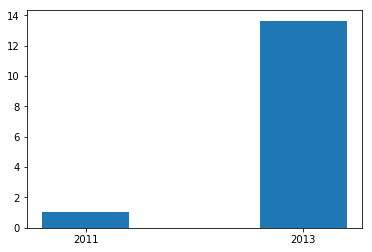

In [14]:
# Enter a pitcher's name
name = 'Rex Brothers'

pit_save_info(name)

In [15]:
df_pitchers[df_pitchers['FULL_NAME'] == name]['save_dif'].values.flatten().tolist()

[1.027749229188078, 13.654914524498869]

In [16]:
df_pitchers.columns = ['Name', 'year', 'save2.0', 'made', 'blown', 'attempts']
df_pitchers.head()


,Name,year,save2.0,made,blown,attempts
0,A.J. Ramos,2013,-4.000000,0,2,2
1,Aaron Crow,2011,-3.834862,0,2,2
2,Aaron Crow,2012,0.698552,2,2,4
3,Aaron Crow,2013,1.027749,1,0,1
4,Aaron Heilman,2010,3.148997,3,0,3


In [17]:
df_pitchers.to_csv('pitchers.csv', index=False)